In [8]:
#GAN for image generation
#https://www.youtube.com/watch?v=ABaZ_tecZ3U&list=PLWKjhJtqVAbm3T2Eq1_KgloC7ogdXxdRa&index=6

import os
import torch
import torchvision
import torchvision.transforms as tt
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [12]:
 #Get the parent directory and enter files
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '\\data_source\\anime-faces-images'


print(os.listdir(DATA_DIR +'\\images')[:10])



['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [13]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size,shuffle=True, num_workers=3, pin_memory = True)


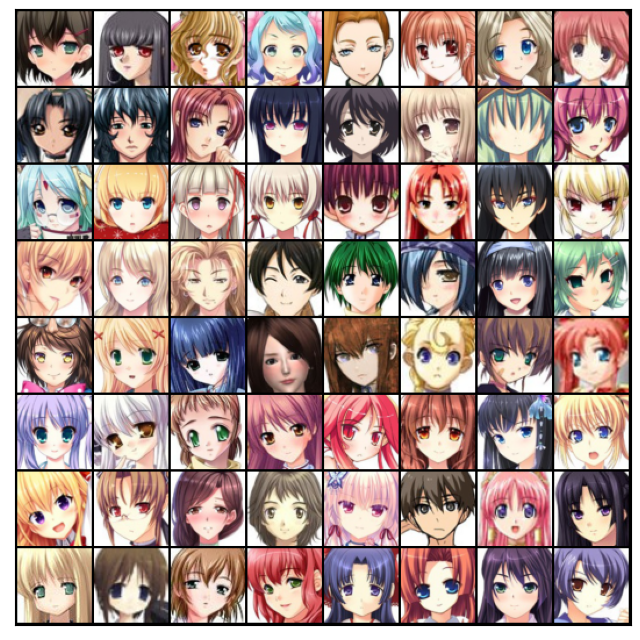

In [14]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [15]:
#Utilize GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    "Wrap a dataloader to move data to a device"
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
print("device: ", device)

train_dl = DeviceDataLoader(train_dl, device)

device:  cuda


In [16]:
#GAN Discriminator network 
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #out = 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #out = 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #out = 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #out = 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias = False),
    #out = 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

discriminator = to_device(discriminator, device)


In [17]:
#GAN Generator network 

latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out = 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out = 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out = 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out = 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias = False),
    nn.Tanh()
    #out = 3 x 64 x 64
)

generator = to_device(generator, device)


torch.Size([128, 3, 64, 64])


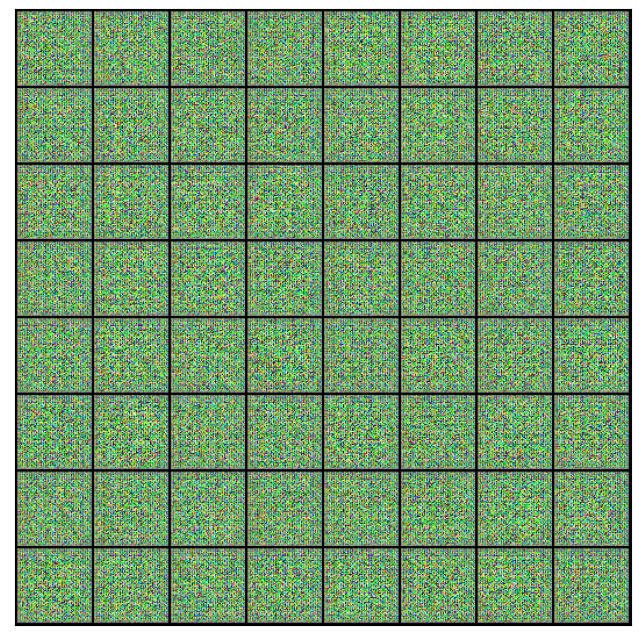

In [18]:
xb = torch.randn(batch_size, latent_size,1,1)   #random latent tensors
xb = to_device(xb, device)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.detach().cpu())

In [19]:
def train_discriminator(real_images, opt_d):
    #Clear discriminator gradients
    opt_d.zero_grad()

    #Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    #Generate fake images
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    #Pass fake images trough discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    #Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    #Clear generator gradients
    opt_g.zero_grad()

    #Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    #Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    #Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()


In [21]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


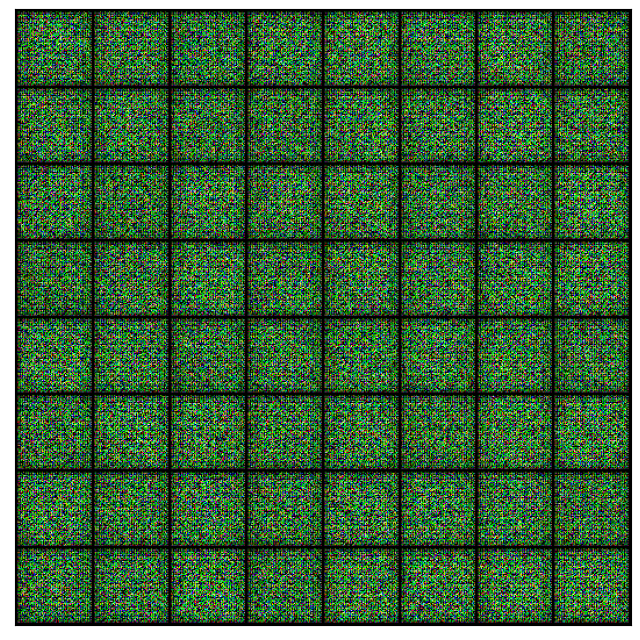

In [22]:
fixed_latent = torch.randn(64, latent_size,1,1,device=device)

save_samples(0,fixed_latent)

In [24]:
from tqdm import tqdm

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    #Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            #Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            #Train generator
            loss_g = train_generator(opt_g)
        
        #Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        #Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                                                            epoch+1,epochs,loss_g, loss_d, real_score, fake_score))
        
        #Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

lr = 0.0002
epochs = 30

history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

100%|██████████| 497/497 [04:29<00:00,  1.84it/s]


Epoch [1/6], loss_g: 8.0125, loss_d: 0.4740, real_score: 0.9427, fake_score: 0.3171
Saving generated-images-0001.png


100%|██████████| 497/497 [04:12<00:00,  1.97it/s]


Epoch [2/6], loss_g: 3.2372, loss_d: 0.2475, real_score: 0.9047, fake_score: 0.0960
Saving generated-images-0002.png


100%|██████████| 497/497 [04:04<00:00,  2.03it/s]


Epoch [3/6], loss_g: 5.7558, loss_d: 0.1278, real_score: 0.9584, fake_score: 0.0736
Saving generated-images-0003.png


100%|██████████| 497/497 [04:08<00:00,  2.00it/s]


Epoch [4/6], loss_g: 7.6686, loss_d: 0.1184, real_score: 0.9892, fake_score: 0.0878
Saving generated-images-0004.png


100%|██████████| 497/497 [04:22<00:00,  1.89it/s]


Epoch [5/6], loss_g: 9.4613, loss_d: 0.1832, real_score: 0.8812, fake_score: 0.0001
Saving generated-images-0005.png


100%|██████████| 497/497 [04:27<00:00,  1.86it/s]

Epoch [6/6], loss_g: 12.3284, loss_d: 0.4496, real_score: 0.7320, fake_score: 0.0000
Saving generated-images-0006.png


Text(0.5, 1.0, 'Losses')

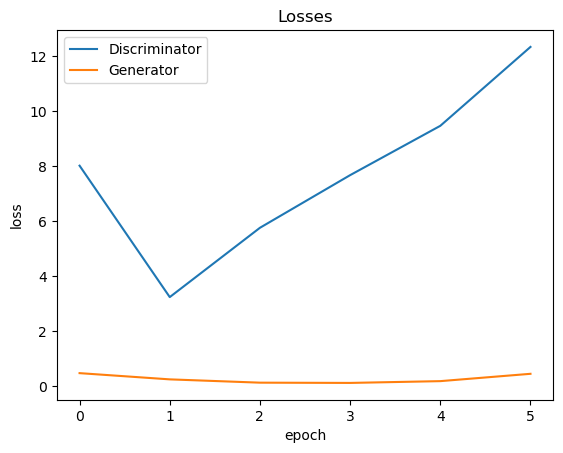

In [34]:
losses_d = history[0]
losses_g = history[1]

plt.plot(losses_d,'-')
plt.plot(losses_g,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

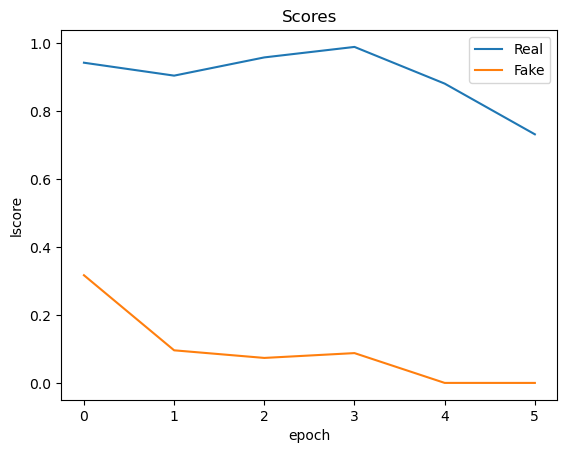

In [35]:
real_scores = history[2]
fake_scores = history[3]

plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epoch')
plt.ylabel('lscore')
plt.legend(['Real','Fake'])
plt.title('Scores')